In [45]:
import argparse
import json
import logging
import pickle
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [46]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 14,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [47]:
api = wandb.Api(timeout=200)

In [48]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in tqdm(runs):
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

In [60]:
relabels = {
    "xppo-512-5": "xPPO",
    'tuned_xppo': 'xPPO',
    "basline_stbl_ppo": 'PPO-clip',
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'rollout/SuccessRate':'Average Success Rate',
    "train/std" :'Action Distribution STD', 
}

## Pick-Place

In [61]:
env = "PickPlace-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "train/std"),
    ("basline_stbl_ppo", 'global_step', "train/std")
]

extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 20e6),
    extra_filter
)

Got 9 runs for group tuned_xppo


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


In [62]:
run.config['env']

'<SawyerPickPlaceEnvV2 instance>'

In [63]:
all_data

,Total Environment Steps,Action Distribution STD,Algorithm,run
0,0.000000e+00,1.000425,xPPO,<Run resl-mixppo/stabilized-rl/o8u07ze1 (finis...
1,2.002002e+04,0.994755,xPPO,<Run resl-mixppo/stabilized-rl/o8u07ze1 (finis...
2,4.004004e+04,0.974187,xPPO,<Run resl-mixppo/stabilized-rl/o8u07ze1 (finis...
3,6.006006e+04,0.959430,xPPO,<Run resl-mixppo/stabilized-rl/o8u07ze1 (finis...
4,8.008008e+04,0.956428,xPPO,<Run resl-mixppo/stabilized-rl/o8u07ze1 (finis...
...,...,...,...,...
11995,1.991992e+07,0.191446,PPO-clip,<Run resl-mixppo/stabilized-rl/w8dcaxzs (finis...
11996,1.993994e+07,0.199810,PPO-clip,<Run resl-mixppo/stabilized-rl/w8dcaxzs (finis...
11997,1.995996e+07,0.199498,PPO-clip,<Run resl-mixppo/stabilized-rl/w8dcaxzs (finis...
11998,1.997998e+07,0.195215,PPO-clip,<Run resl-mixppo/stabilized-rl/w8dcaxzs (finis...


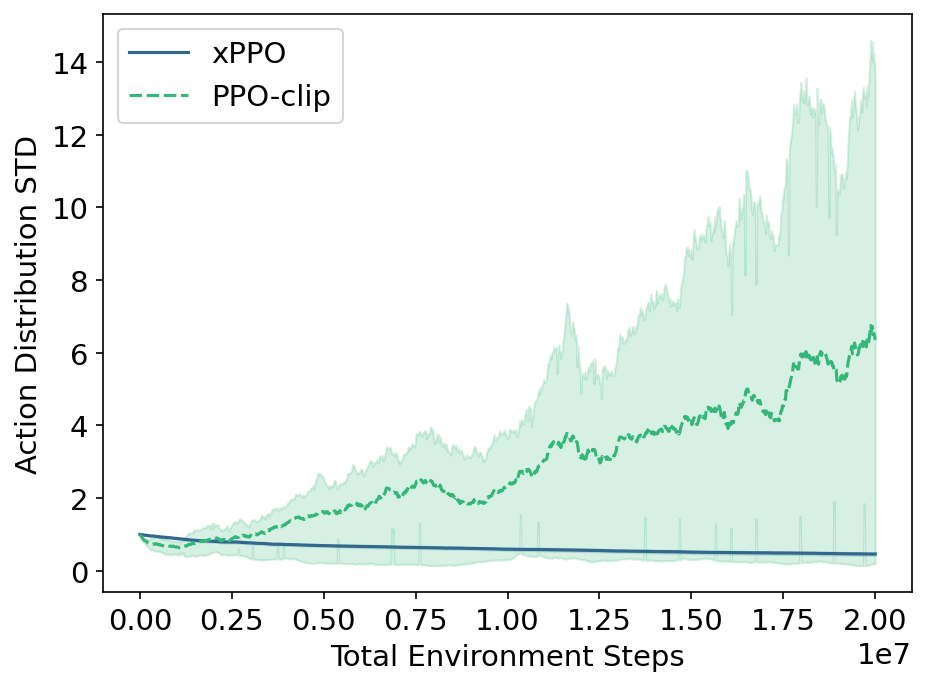

In [64]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Action Distribution STD",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(f"XPPO_vs_ppo_STD_{env}.pdf")

## Window-Open

In [65]:
env = "WindowOpen-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "train/std"),
    ("basline_stbl_ppo", 'global_step', "train/std"),
]

extra_filter = {"tags": {"$in": ["xppo_window-open", 'stbl_ppo_window-open_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    extra_filter
)

Got 4 runs for group tuned_xppo


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


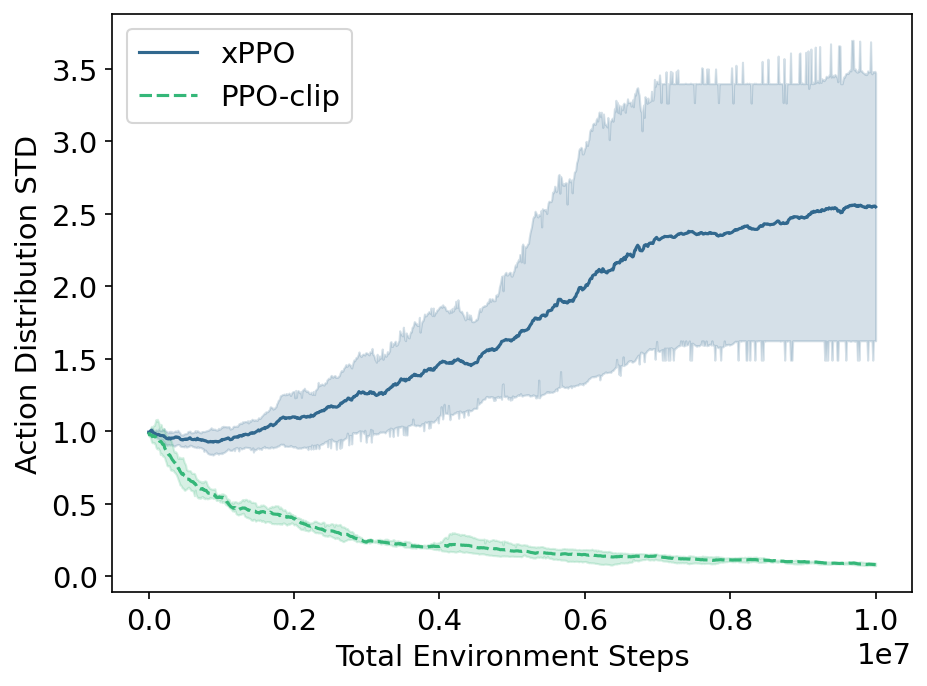

In [66]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Action Distribution STD",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="upper left")

plt.tight_layout()
plt.savefig(f"XPPO_vs_ppo_STD_{env}.pdf")

## Button-press-topdown

In [67]:
env = "ButtonPressTopdown-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "train/std"),
    ("basline_stbl_ppo", 'global_step', "train/std"),
]

extra_filter = {"tags": {"$in": ["xppo_button-press-topdown", 'stbl_ppo_button-press-topdown_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 7e6),
    extra_filter
)

Got 9 runs for group tuned_xppo


100%|██████████| 9/9 [00:03<00:00,  2.37it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


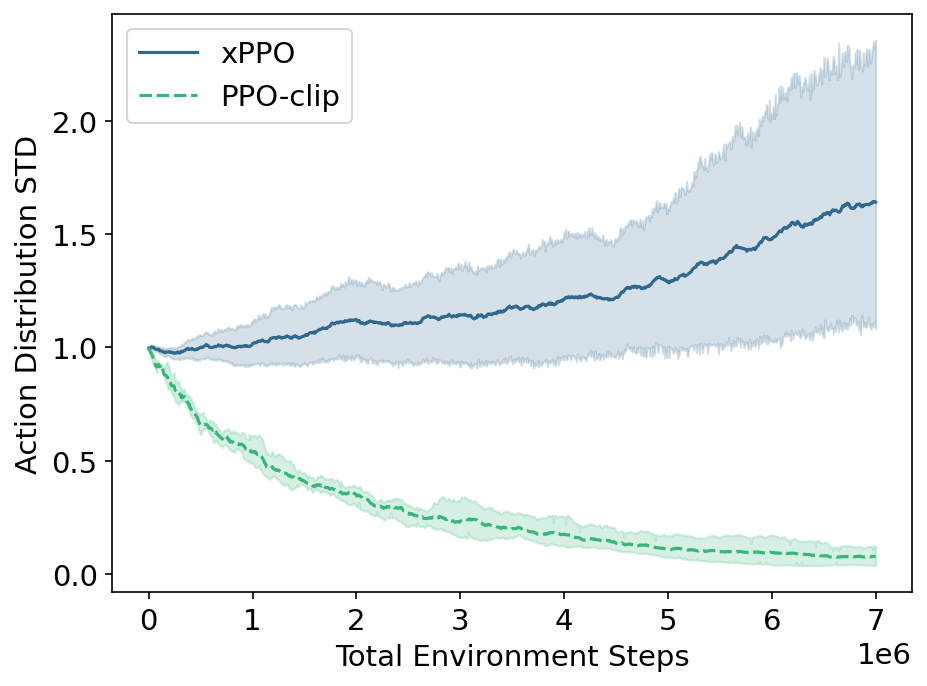

In [68]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Action Distribution STD",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="upper left")

plt.tight_layout()
plt.savefig(f"XPPO_vs_ppo_STD_{env}.pdf")

## Reach

In [69]:
env = "Reach-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "train/std"),
    ("basline_stbl_ppo", 'global_step', "train/std"),  
]

extra_filter = {"tags": {"$in": ["xppo_reach", 'stbl_ppo_reach_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    extra_filter
)

Got 3 runs for group tuned_xppo


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


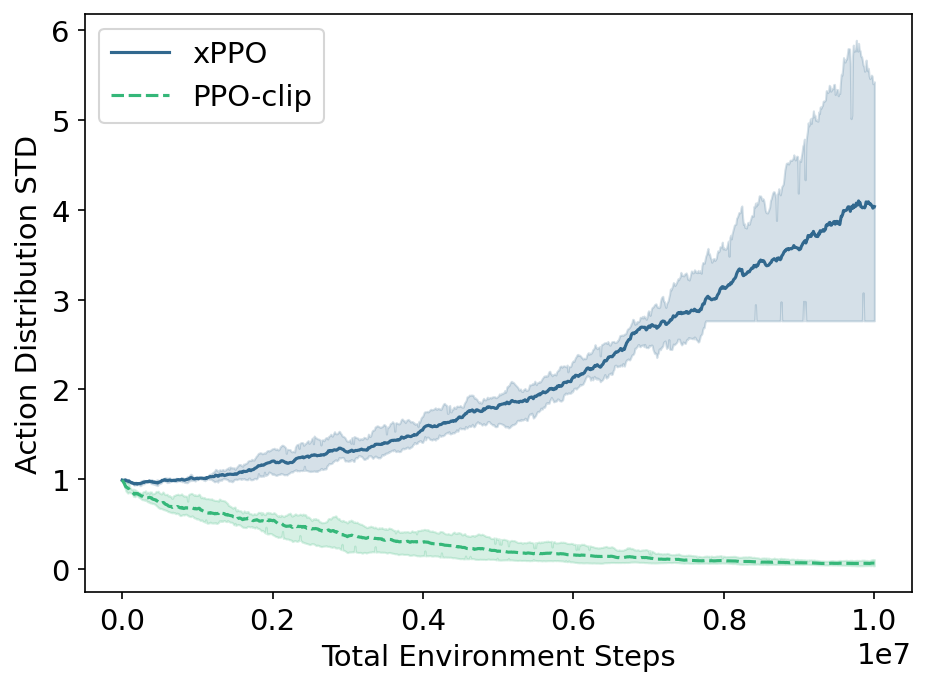

In [70]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Action Distribution STD",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(f"XPPO_vs_ppo_STD_{env}.pdf")